In [1]:
# Research question:
# "How does the relationship between smartphone use (in time and habits) and academic performance
#  and mental health differ across school grades?"

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1) LOAD DATA
# -----------------------------
CSV_PATH = "teen_phone_addiction_processed.csv"
df = pd.read_csv(CSV_PATH)

# -----------------------------
# 2) DEFINE/COERCE NUMERIC COLS
# -----------------------------
num_candidates = [
    'Age','Daily_Usage_Hours','Sleep_Hours','Academic_Performance','Social_Interactions',
    'Exercise_Hours','Anxiety_Level','Depression_Level','Self_Esteem','Parental_Control',
    'Screen_Time_Before_Bed','Phone_Checks_Per_Day','Apps_Used_Daily','Time_on_Social_Media',
    'Time_on_Gaming','Time_on_Education','Family_Communication','Weekend_Usage_Hours','Addiction_Level'
]
for c in num_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# -----------------------------
# 3) MENTAL HEALTH (flip so higher = WORSE)
#    Build a z-composite where higher = BETTER, then flip to "risk"
# -----------------------------
mh_pos = [c for c in ['Sleep_Hours','Self_Esteem','Social_Interactions','Exercise_Hours','Family_Communication'] if c in df.columns]
mh_neg = [c for c in ['Anxiety_Level','Depression_Level','Addiction_Level'] if c in df.columns]
if not mh_pos or not mh_neg:
    raise ValueError("Missing mental-health components. Check column names in the dataset.")

# z-score then combine (+ for positives, - for negatives) → higher = better
for c in mh_pos + mh_neg:
    df[f"z_{c}"] = (df[c] - df[c].mean()) / df[c].std(ddof=0)
df['Mental_Health_Index'] = df[[f"z_{c}" for c in mh_pos]].mean(axis=1) - df[[f"z_{c}" for c in mh_neg]].mean(axis=1)

# === CHANGE: define Mental_Health_Risk so HIGHER = WORSE (easier to read) ===
df['Mental_Health_Risk'] = -df['Mental_Health_Index']

# -----------------------------
# 4) OUTCOMES & PREDICTORS
# -----------------------------
# Outcomes
df = df.dropna(subset=['Academic_Performance','Mental_Health_Risk'])

# Smartphone use (time + habits)
use_vars = [c for c in [
    'Daily_Usage_Hours','Screen_Time_Before_Bed','Phone_Checks_Per_Day',
    'Apps_Used_Daily','Time_on_Social_Media','Time_on_Gaming',
    'Time_on_Education','Weekend_Usage_Hours','Addiction_Level'
] if c in df.columns]
if not use_vars:
    raise ValueError("No smartphone-use variables found. Check column names.")

# Optional continuous controls
controls = [c for c in ['Parental_Control','Exercise_Hours'] if c in df.columns]

# -----------------------------
# 5) GRADE ENCODING (robust to either a single 'Grade' col or existing dummies)
# -----------------------------
grade_dummies = [c for c in df.columns if c.startswith('School_Grade_') or c.startswith('Grade_')]

if not grade_dummies:
    candidate_grade_cols = [c for c in df.columns if c.lower() in {'grade','school_grade','school grade'}]
    if candidate_grade_cols:
        gcol = candidate_grade_cols[0]
        df[gcol] = df[gcol].astype(str)
        df = pd.get_dummies(df, columns=[gcol], drop_first=True)
        grade_dummies = [c for c in df.columns if c.startswith(gcol + "_")]
    else:
        raise ValueError("No grade information found. Expect either 'Grade' column or dummy columns like 'School_Grade_10th'.")

for c in grade_dummies:
    if df[c].dtype == bool:
        df[c] = df[c].astype(int)

# -----------------------------
# 6) STANDARDIZE PREDICTORS (NOT outcomes)
# -----------------------------
scale_cols = use_vars + controls
scaler = StandardScaler()
df[[f"std_{c}" for c in scale_cols]] = scaler.fit_transform(df[scale_cols])

use_std = [f"std_{c}" for c in use_vars]
ctrl_std = [f"std_{c}" for c in controls]

# -----------------------------
# 7) BUILD FORMULAS WITH USE × GRADE INTERACTIONS
# -----------------------------
inter_terms = [f"{u}:{g}" for u in use_std for g in grade_dummies]
rhs_common = " + ".join(use_std + ctrl_std + grade_dummies + inter_terms)

formula_acad = f"Academic_Performance ~ {rhs_common}"
# === CHANGE: model uses Mental_Health_Risk (higher = worse) ===
formula_mh   = f"Mental_Health_Risk ~ {rhs_common}"

# -----------------------------
# 8) FIT MODELS (robust SE: HC3)
# -----------------------------
m_acad = smf.ols(formula_acad, data=df).fit(cov_type='HC3')
m_mh   = smf.ols(formula_mh,   data=df).fit(cov_type='HC3')

print("\n=== Academic Performance ~ Smartphone Use × Grade (HC3) ===")
print(m_acad.summary())
print("\n=== Mental Health RISK ~ Smartphone Use × Grade (HC3) ===")
print(m_mh.summary())

# -----------------------------
# 9) TIDY TABLES: INTERACTIONS
# -----------------------------
def interaction_table(model, use_prefix="std_"):
    rows = []
    ci = model.conf_int()
    for term in model.params.index:
        if ":" in term and term.startswith(use_prefix):
            rows.append({
                "Term": term,
                "Coef": model.params[term],
                "SE": model.bse[term],
                "p_value": model.pvalues[term],
                "CI_low": ci.loc[term, 0],
                "CI_high": ci.loc[term, 1],
            })
    out = pd.DataFrame(rows).sort_values("p_value")
    return out

acad_int = interaction_table(m_acad)
mh_int   = interaction_table(m_mh)

acad_int.to_csv("interactions_academic_use_x_grade.csv", index=False)
# === CHANGE: clearer filename for risk outcome ===
mh_int.to_csv("interactions_mentalhealthRISK_use_x_grade.csv", index=False)

print("\nSaved CSVs:")
print(" - interactions_academic_use_x_grade.csv")
print(" - interactions_mentalhealthRISK_use_x_grade.csv")

# -----------------------------
# 10) QUICK, HUMAN-READABLE SUMMARY
#     Now that higher = worse, positive = more risk, negative = less risk
# -----------------------------
def summarize(sig_df, label, alpha=0.05, risk_outcome=False):
    sig = sig_df[sig_df["p_value"] < alpha]
    if sig.empty:
        print(f"\n{label}: No significant differences in the smartphone-use effect across grades (no use×grade terms at p<{alpha}).")
    else:
        print(f"\n{label}: Significant grade differences in the smartphone-use effect (p<{alpha}):")
        for _, r in sig.iterrows():
            if risk_outcome:
                direction = "stronger increase in risk in that grade" if r["Coef"] > 0 else "weaker or protective in that grade"
            else:
                direction = "more positive in that grade" if r["Coef"] > 0 else "more negative in that grade"
            print(f" - {r['Term']}: coef={r['Coef']:.3f}, p={r['p_value']:.4f} → {direction}")

print("\n================  INTERPRETATION  ================")
summarize(acad_int, "ACADEMIC PERFORMANCE")
# === CHANGE: pass risk_outcome=True so the wording matches the flipped sign ===
summarize(mh_int,   "MENTAL HEALTH RISK", risk_outcome=True)

print("\nNotes:")
print("• For Mental_Health_Risk, higher values mean worse mental health; positive coefficients indicate increased risk.")
print("• Each significant use×grade term means the slope linking that smartphone behavior and the outcome differs for that grade vs. the baseline grade.")
print("• Standardized predictors make effect sizes comparable across different phone-use measures.")
print("• HC3 robust standard errors are used to protect against heteroskedasticity.")



=== Academic Performance ~ Smartphone Use × Grade (HC3) ===
                             OLS Regression Results                             
Dep. Variable:     Academic_Performance   R-squared:                       0.024
Model:                              OLS   Adj. R-squared:                  0.003
Method:                   Least Squares   F-statistic:                     1259.
Date:                  Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                          01:49:13   Log-Likelihood:                -12281.
No. Observations:                  3000   AIC:                         2.469e+04
Df Residuals:                      2938   BIC:                         2.506e+04
Df Model:                            61                                         
Covariance Type:                    HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 71, but rank is 62
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 71, but rank is 62
  warnings.warn('covariance of constraints does not have full '


/tmp/ipython-input-557243565.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = (purpose_long.groupby(['Grade','Purpose'])['Value'].mean()


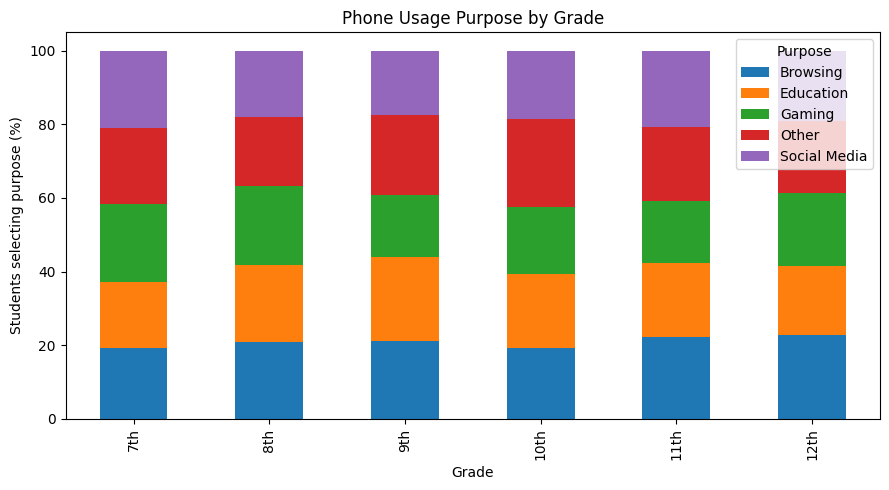

/tmp/ipython-input-557243565.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby('Grade')[y].apply(mean_ci).apply(pd.Series)


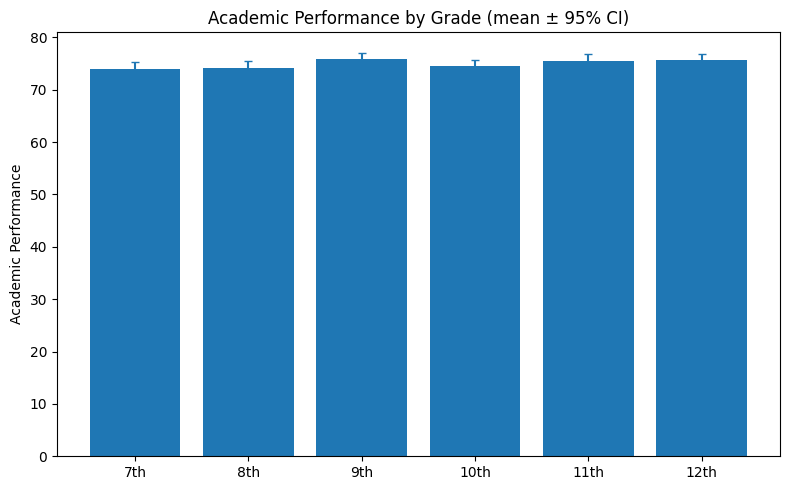

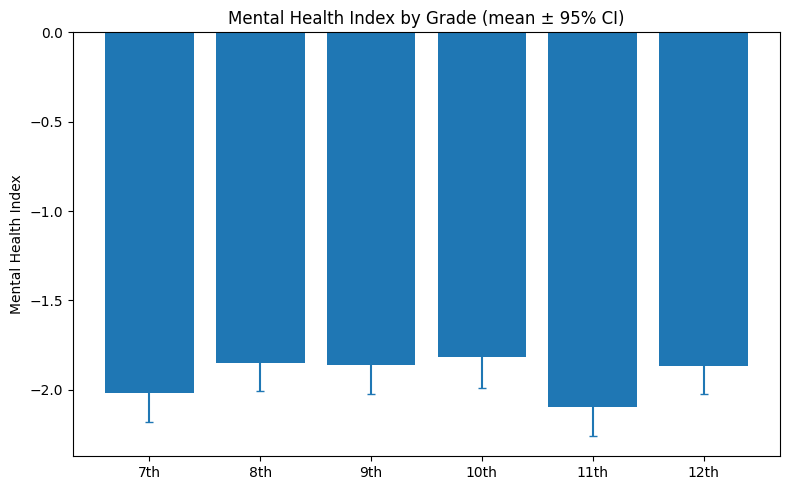

In [2]:
# --- Charts: (1) Grade × App Purpose, (2) Grade vs Academic & Mental Health
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("teen_phone_addiction_processed.csv")

# ---------- Mental Health Index (if missing)
if 'Mental_Health_Index' not in df.columns:
    mh_pos = [c for c in ['Sleep_Hours','Self_Esteem','Social_Interactions','Exercise_Hours','Family_Communication'] if c in df.columns]
    mh_neg = [c for c in ['Anxiety_Level','Depression_Level','Addiction_Level'] if c in df.columns]
    for c in mh_pos + mh_neg:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df['Mental_Health_Index'] = df[mh_pos].mean(axis=1) - df[mh_neg].mean(axis=1)

# ---------- Build Grade column (works if dummies or single col)
grade_cols = [c for c in df.columns if c.startswith('School_Grade_') or c.startswith('Grade_')]
if grade_cols:
    for c in grade_cols:
        if df[c].dtype == bool:
            df[c] = df[c].astype(int)
    def infer_grade(r):
        hits = [g for g in grade_cols if r[g] == 1]
        return hits[0].split('_')[-1] if hits else 'Unknown'
    df['Grade'] = df.apply(infer_grade, axis=1)
elif 'Grade' not in df.columns:
    raise ValueError("No grade information found.")
df['Grade'] = df['Grade'].astype(str)

# Order grades nicely
order = ['7th','8th','9th','10th','11th','12th']
df['Grade'] = pd.Categorical(df['Grade'], categories=[g for g in order if g in df['Grade'].unique()], ordered=True)

# ---------- 1) App usage by grade (either purpose dummies or time columns)
purpose_dummies = [c for c in df.columns if c.startswith('Phone_Usage_Purpose_')]
time_cols = [c for c in ['Time_on_Education','Time_on_Gaming','Time_on_Social_Media'] if c in df.columns]

if purpose_dummies:
    for c in purpose_dummies:
        if df[c].dtype == bool:
            df[c] = df[c].astype(int)
    purpose_long = df[['Grade'] + purpose_dummies].melt(id_vars='Grade', var_name='Purpose', value_name='Value')
    purpose_long['Purpose'] = purpose_long['Purpose'].str.replace('Phone_Usage_Purpose_','', regex=False)
    prop = (purpose_long.groupby(['Grade','Purpose'])['Value'].mean()
            .reset_index()
            .pivot(index='Grade', columns='Purpose', values='Value').fillna(0.0))
    ax = prop.mul(100).plot(kind='bar', stacked=True, figsize=(9,5))
    ax.set_ylabel('Students selecting purpose (%)')
    ax.set_title('Phone Usage Purpose by Grade')
    plt.tight_layout()
    plt.show()
elif time_cols:
    means = df.groupby('Grade')[time_cols].mean()
    ax = means.plot(kind='bar', figsize=(9,5))
    ax.set_ylabel('Average hours per day')
    ax.set_title('Average Time Spent on Apps by Grade')
    plt.tight_layout()
    plt.show()
else:
    print("No app-purpose data found; skipping first chart.")

# ---------- 2) Academic & Mental Health by Grade
def mean_ci(series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if len(s) == 0: return (np.nan, np.nan)
    mean, se = s.mean(), s.std(ddof=1)/np.sqrt(len(s))
    return mean, 1.96*se

for y in ['Academic_Performance','Mental_Health_Index']:
    if y not in df.columns: continue
    stats = df.groupby('Grade')[y].apply(mean_ci).apply(pd.Series)
    stats.columns = ['mean','ci']
    plt.figure(figsize=(8,5))
    plt.bar(stats.index, stats['mean'])
    plt.errorbar(stats.index, stats['mean'], yerr=stats['ci'], fmt='none', capsize=3)
    plt.ylabel(y.replace('_',' '))
    plt.title(f'{y.replace("_"," ")} by Grade (mean ± 95% CI)')
    plt.tight_layout()
    plt.show()
